# How to Solve the CartPole in 5 Lines

In [2]:
import gym
import pyvirtualdisplay
import numpy as np
import os

# Common imports
import numpy as np
import random
import os
import collections

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [5]:
!pip install array2gif

In [3]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
env = gym.make('CartPole-v1')

# Understanding the Cart-Pole Environment (velocity and position arrow at wrong direction)

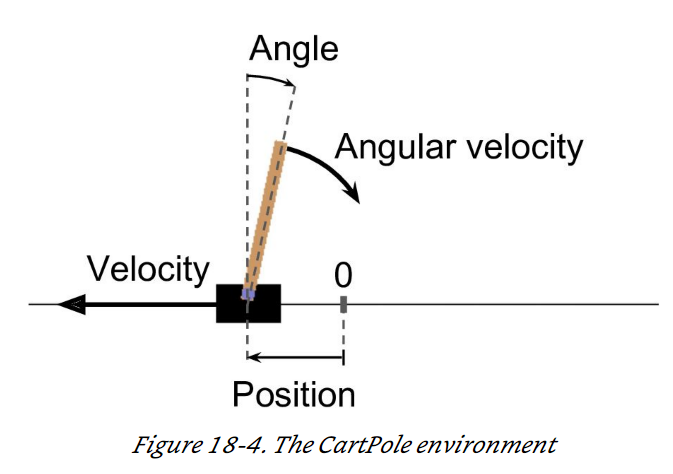

|Observation|Action|Reward|Done|
|---|---|---|---|
|$(x, v, \theta, \omega)$| {0, 1} | {0, 1} | {0, 1} |
|$x$: position | 0: push to the left | 0: game ended | 0: game continues |
|$v$: velocity | 1: push to the right | 1: game continues | 1: game ended |
|$\theta$: angle |  | | |
|$\omega$: angular velocity | | | |

## Initial observation

### Numerical Representation of an Observation

In [6]:
env.seed(42)
obs = env.reset()

In [7]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [8]:
Obs = collections.namedtuple("CartPole_obs", "x v theta omega")  # position, velocity, angle, angular velocity

In [9]:
Obs(*obs)

CartPole_obs(x=-0.012585662189167172, v=-0.0015661448344362477, theta=0.04207708208612142, omega=-0.0018054520701298524)

### Visual Representation of an Observations

In [10]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [11]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

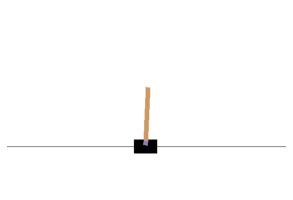

In [12]:
img = plot_environment(env)
plt.show()

### Actions Space

In [13]:
env.action_space

Discrete(2)

## Perturbe the environment through and action

In [14]:
env.seed(42)
obs = env.reset()
obs0 = Obs(*obs)
print(obs0)

CartPole_obs(x=-0.012585662189167172, v=-0.0015661448344362477, theta=0.04207708208612142, omega=-0.0018054520701298524)


### Push to the right

When a force pushes to the right, the box has an acceleration $a > 0$ (to the right), and angular acceleration  $\alpha < 0 $ (counter clock-wise)

Therefore, we expect velocity $v_1 > v_0$, angular velocity $\omega_1 < \omega_0$

Note that due to the inertia, the relation in $x$ and $\theta$ are undetermined

In [15]:
obs, reward, done, info = env.step(1)
obs1 = Obs(*obs)
print(obs1)

CartPole_obs(x=-0.012616985085855898, v=0.19292789026810803, theta=0.04204097304471882, omega=-0.28092126973427073)


In [16]:
print(obs1.v > obs0.v, obs1.omega < obs0.omega)

True True


### Push to the left

In [17]:
obs, reward, done, info = env.step(0)
obs2 = Obs(*obs)
print(obs2)

CartPole_obs(x=-0.008758427280493737, v=-0.002767750530172003, theta=0.03642254765003341, omega=0.024719224389911088)


In [18]:
print(obs2.v < obs1.v, obs2.omega > obs1.omega)

True True


## Visualize a Series of Actions / Observations

### Recording a scenario

In [19]:
def record_scenario(env, policy, num_frames=100) -> dict:
    frames = []
    obs_mat = np.empty((num_frames, 4))
    actions = np.empty((num_frames,))
    rewards = np.empty((num_frames,))
    dones = np.empty((num_frames,), dtype=int)
    first_done_info = ''
    obs = env.reset()  # initial observation
    for i in range(num_frames):
        action = policy(obs)
        obs, reward, done, info = env.step(action)
        img = env.render(mode="rgb_array")
        frames.append(img)
        obs_mat[i,:] = obs
        actions[i] = action
        rewards[i] = reward
        dones[i] = int(done)
        if done and first_done_info == '':
            first_done_info = info
    record = {'frames': frames, 'obs': obs_mat, 'actions': actions, 'rewards': 
              rewards, 'dones': dones, 'first_done_info':first_done_info}
    return record

### Plotting a scenario

In [20]:
def update_scene(num, frames, patch, time_text, obs_mat, actions, cum_rewards, dones):
    patch.set_data(frames[num])
    text = f"frame: {num}"
    text += ", Obs: ({:.3f}, {:.3f}, {:.3f}, {:.3f})\n".format(*obs_mat[num,:])
    text += f"Action: {actions[num]}"
    text += f", Cumulative Reward: {cum_rewards[num]}"
    text += f", Done: {dones[num]}"
    time_text.set_text(text)
    return patch, time_text

def plot_animation(record, repeat=False, interval=40):
    '''record should contain
    frames: list of N frames
    obs: (N, 4) array of observations
    actions: (N, ) array of actions {0, 1}
    rewards: (N, ) array of rewards at each step {0, 1}
    dones: (N, 1) array of dones {0, 1}
    '''
    cum_rewards = np.cumsum(record['rewards'])
    frames = record['frames']
    fig = plt.figure()
    patch = plt.imshow(record['frames'][0])
    ax = plt.gca()
    time_text = ax.text(0., 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch, time_text, record['obs'], record['actions'], cum_rewards, record['dones']),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Hard Coded Policies

## A Random Policy
Push to the right if the pole tiled to the right

In [21]:
def rand_policy(obs):
    return random.randint(0, 1)

### Test this policy

In [22]:
N_scenario = 1000
MAX_ACTIONS = 500

In [23]:
def test_policy(policy_func, n_scenario = N_scenario, max_actions = MAX_ACTIONS, verbose=False):
    final_rewards = []
    for episode in range(n_scenario):
        if verbose and episode % 50 == 0:
            print(episode)
        episode_rewards = 0
        obs = env.reset()  # reset to a random position
        for step in range(max_actions):
            action = policy_func(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        final_rewards.append(episode_rewards)
    return final_rewards

In [24]:
def plot_policy(final_rewards, policy_name:str=''):
    fig = plt.plot(range(len(final_rewards)), final_rewards)
    plt.grid()
    plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.min(final_rewards)))
    plt.ylabel('Cum Reward')
    plt.xlabel('Iteration')
    plt.ylim(0, max(final_rewards)*1.1)
    return fig

In [25]:
env.seed(42)
random.seed(0)

rand_rewards = test_policy(rand_policy)

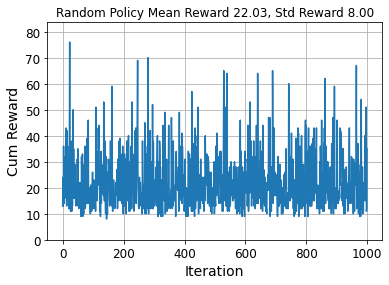

In [26]:
pt = plot_policy(rand_rewards, "Random Policy")

## An Angle $\theta$ Policy

In [27]:
def theta_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [28]:
env.seed(42)
random.seed(0)

theta_rewards = test_policy(theta_policy)

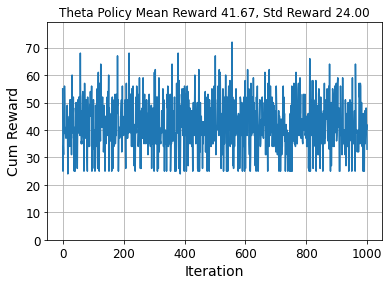

In [29]:
pt = plot_policy(theta_rewards, "Theta Policy")

## Angular Velocity $\omega$ Policy

In [30]:
def omega_policy(obs):
    w = obs[3]
    return 1 if w > 0 else 0

In [31]:
env.seed(42)
random.seed(0)

omega_rewards = test_policy(omega_policy)

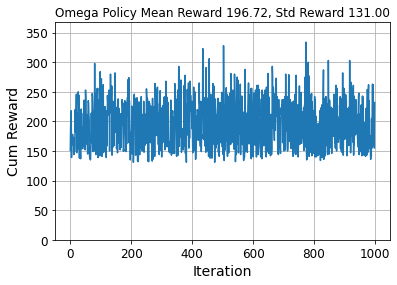

In [32]:
pt = plot_policy(omega_rewards, "Omega Policy")

## A Combined Policy

In [33]:
def theta_omega_policy(obs):
    theta, w = obs[2:4]
    if abs(theta) < 0.03:
        return 0 if w < 0 else 1
    else:
        return 0 if theta < 0 else 1

In [34]:
env.seed(42)
random.seed(0)

# the cart-pole experiment will end if it lasts more than 500 steps, with info="'TimeLimit.truncated': True"
theta_omega_rewards = test_policy(theta_omega_policy, max_actions=510)

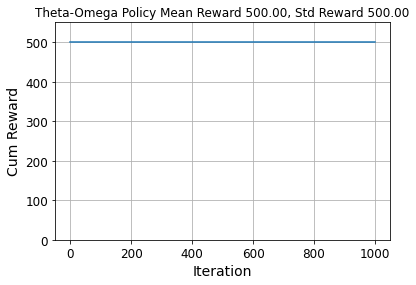

In [35]:
plot_policy(theta_omega_rewards, "Theta-Omega Policy")

## Visualize Hard Coded Policies

In [36]:
rand_record = record_scenario(env, rand_policy, 100)

/opt/conda/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [40]:
theta_record = record_scenario(env, theta_policy, 200)

In [41]:
omega_record = record_scenario(env, omega_policy, 220)

In [42]:
theta_omega_record = record_scenario(env, theta_omega_policy, 500)

In [43]:
plot_animation(rand_record)

## Generate GIF

In [44]:
from array2gif import write_gif

In [75]:
theta_record['frames'][1].shape

(400, 600, 3)

In [115]:
write_gif([np.transpose(f, axes=[2,0, 1]) for f in theta_record['frames']], 'jian_img_out/theta_record.gif', fps=30)